# Assignment 06
Bill Henderson

CSCI-E-116

Spring 2025

### Imports

In [197]:
import yaml
from fredapi import Fred
import datetime
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa as smt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Part A. Running Three Models: VAR Level, VAR Growth and ARIMA 
## Data Collection

In [172]:
keys = yaml.safe_load(open('/Users/hendwi1/.env'))

fred = Fred(keys['fred_key'])
obs_start = "1986-02-01"
obs_end = "2025-1-31"

In [173]:
oil_price = fred.get_series("DCOILWTICO", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Oil price
nasdaq = fred.get_series("NASDAQCOM", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # NASDAQ stock price
payroll = fred.get_series("PAYEMS", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Nonfarm payroll jobs
cpi = fred.get_series("CPILFESL", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Core Consumer Price Index
ffr = fred.get_series("DFF", observation_start=obs_start, observation_end=obs_end).resample('M').mean() # Federal Fund Rate

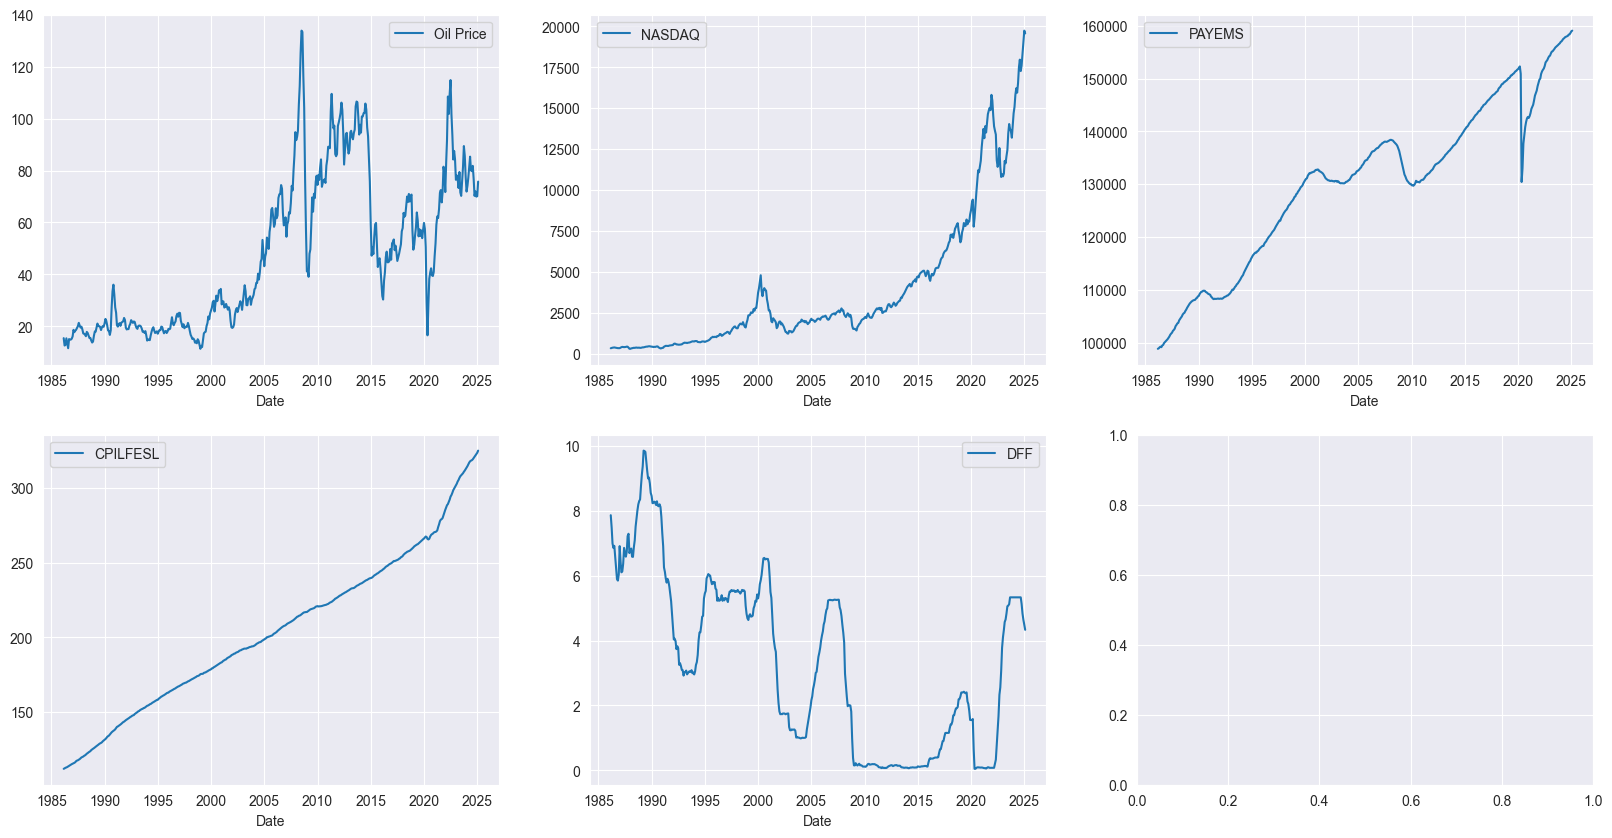

In [174]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
names = ["Oil Price", "NASDAQ","PAYEMS", "CPILFESL", "DFF"]
ax = ax.flatten()
for i, d in enumerate(zip(names,[oil_price, nasdaq, payroll, cpi, ffr])):
    sns.lineplot(data=d[1], ax=ax[i], label=d[0], )
    ax[i].set_xlabel("Date")
plt.show()

## Creating Data0 and Data1

In [175]:
data0_setup = {d[0].lower().replace(" ","_"): d[1] for d in zip(names,
                                                                [oil_price,
                                                                 nasdaq,
                                                                 payroll,
                                                                 cpi,
                                                                 ffr])}
data0 = pd.DataFrame(data0_setup).dropna()


data1_setup = {d[0].lower().replace(" ","_"): d[1] for d in zip(names, 
                                                               [oil_price.apply(np.log).diff()*100, 
                                                                nasdaq.apply(np.log).diff()*100, 
                                                                payroll.apply(np.log).diff()*100, 
                                                                cpi.apply(np.log).diff()*100, 
                                                                ffr])}
data1 = pd.DataFrame(data1_setup).dropna()

## Create the train sets for the above two data frames 

In [176]:
start_train=(1986, 3)
end_train=datetime.datetime(2024,11,30)

train_data0 = data0[data0.index <= end_train]
train_data1 = data1[data1.index <= end_train]
print(f"Training Data\nFirst date: {train_data1.index.min()}\nLast date: {train_data1.index.max()}")

Training Data
First date: 1986-03-31 00:00:00
Last date: 2024-11-30 00:00:00


## Run two VAR models of these 5 variables

In [177]:
def best_VAR_model(d, trend: str,  max_lag=24):

    outputs = []

    results = {}
    for i in range(max_lag):
        r = VAR(
            endog=d
        )
        r_fit = r.fit(trend=trend, maxlags=max_lag, ic='aic')
    return r, r_fit

In [178]:
varmax0, model0 = best_VAR_model(train_data0,'ct')
model0.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 29, Mar, 2025
Time:                     15:13:32
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    25.7794
Nobs:                     443.000    HQIC:                   22.5056
Log likelihood:          -7070.71    FPE:                7.51637e+08
AIC:                      20.3737    Det(Omega_mle):     2.32856e+08
--------------------------------------------------------------------
Results for equation oil_price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -4.000831         9.957258           -0.402           0.688
trend                 0.015314         0.028301            0.541           0.588
L1.oil_price          1.289588         0.058253         

In [179]:
varmax1, model1 = best_VAR_model(train_data1,'c')
model1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 29, Mar, 2025
Time:                     15:13:33
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                  -0.789078
Nobs:                     462.000    HQIC:                  -1.22325
Log likelihood:          -2850.05    FPE:                   0.222005
AIC:                     -1.50519    Det(Omega_mle):        0.187255
--------------------------------------------------------------------
Results for equation oil_price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.175964         0.955621            0.184           0.854
L1.oil_price         0.324016         0.050285            6.444           0.000
L1.nasdaq            0.014843         0.082574            0.

In [180]:
preds0 = pd.DataFrame(model0.forecast(model0.endog, steps=12), index = pd.date_range(start="2024-12-31", end="2025-11-30", freq='M'))
preds0.columns = [f"pred_{i}" for i in train_data0.columns]
preds1 = pd.DataFrame(model1.forecast(model1.endog, steps=12), index = pd.date_range(start="2024-12-31", end="2025-11-30", freq='M'))
preds1.columns = [f"pred_{i}" for i in train_data1.columns]

### Plotted Forecasts

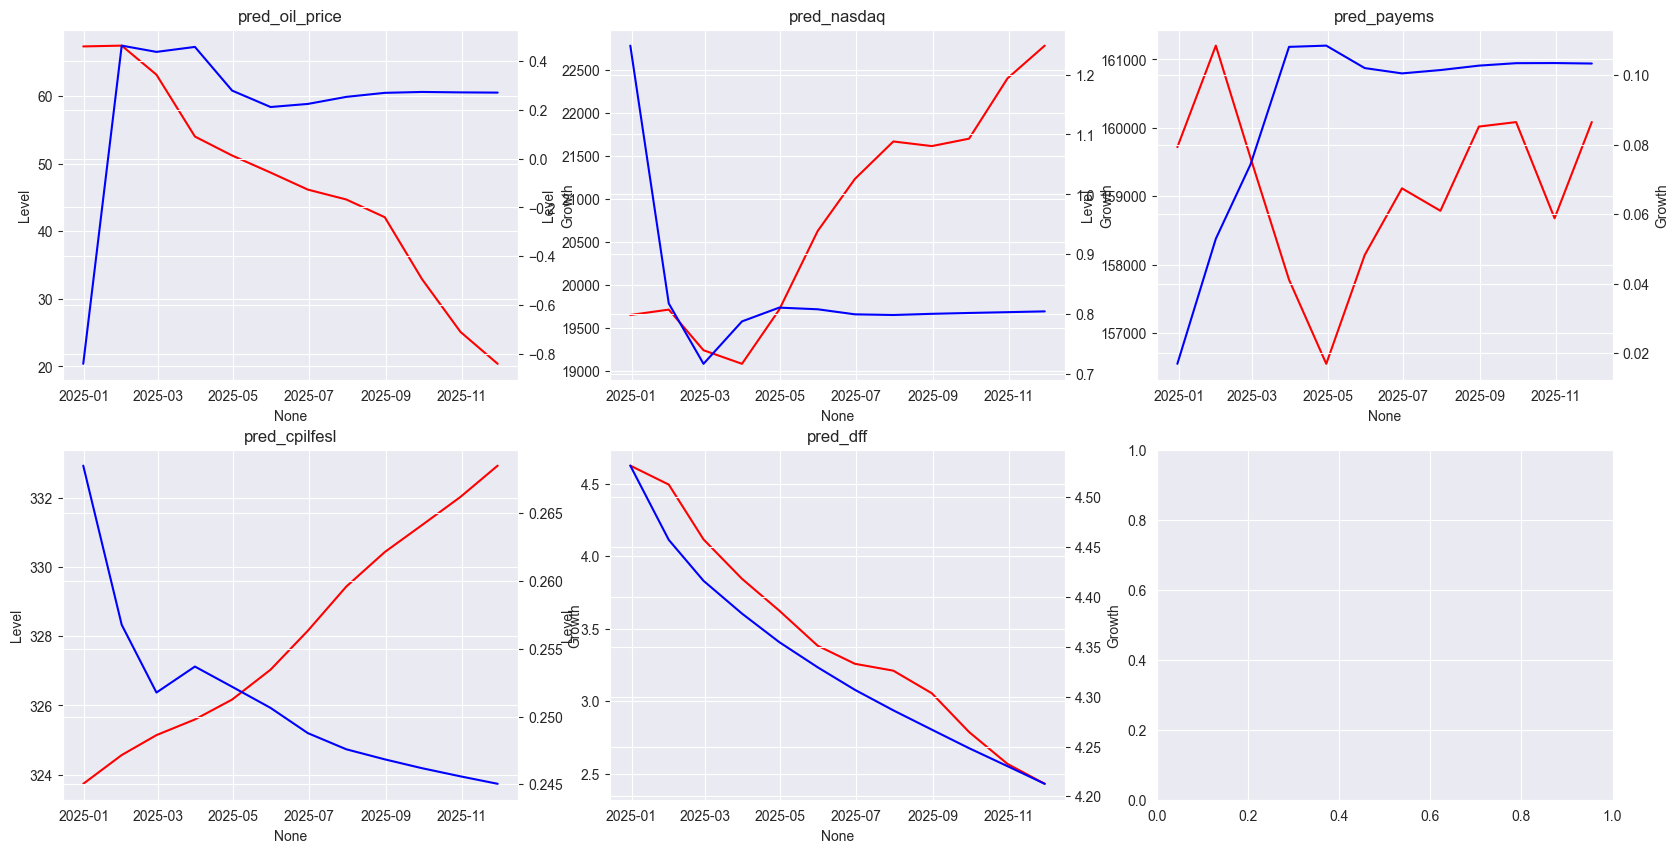

In [210]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax = ax.flatten()
for i,c in enumerate(preds0.columns):
    combined = pd.concat([preds0[c], preds1[c]], axis=1)
    combined.columns = ['Level', 'Growth']
    # fixed_col ="_".join(c.split("_")[1:])
    # combined = pd.melt(combined, var_name="Dataset", value_name = fixed_col, ignore_index=False)
    sns.lineplot(
        data = combined,
        x=combined.index,
        y=combined['Level'],
        ax=ax[i],
        color='red'
    )
    ax[i].set_title(c)
    ax_sec = ax[i].twinx()
    sns.lineplot(
        data = combined,
        x=combined.index,
        y=combined['Growth'],
        ax=ax_sec,
        color='blue'
    )
plt.show()
    

There are some expected results here from the outputs and some oddities. Seing as the growth predictors needed to be put on different axis to see any dynamic response, I plotted both level and growth on separate axis. DFF followed a similar trend in both models, which is expected as it wasn't scaled in any way, but there is a slight difference in magnitude. We'll see later when we check the MSLE which one is a better response. The other predictors have some wildly different responses which are very strange, even some whose slopes are inverted. I don't suspect the scaling to be at fault here since that's log difference, but it would appear the large change in lags between the two models (23 and 3 respectively) gave us very different predictions. 

Below is both models with a 12 lag (non optimized). We can see that the values are far more consistent when the lags match, though the growth model is far more erratic. Hard to tell now if this is reflecting the dataset better or just inconsistent.

[]

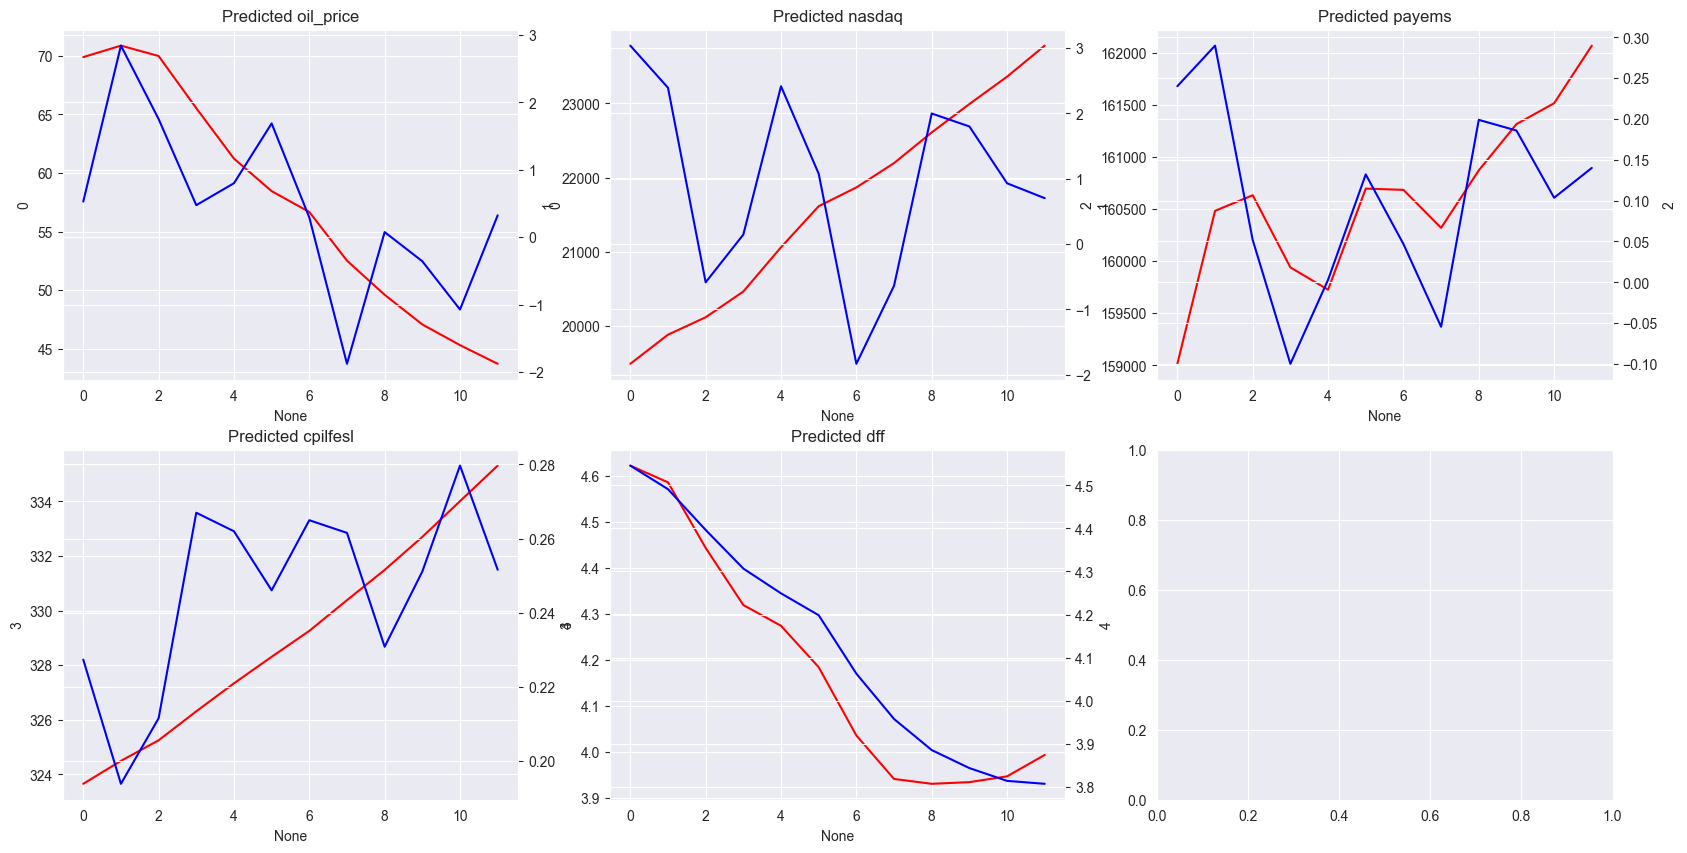

In [219]:
pred0_12l = pd.DataFrame(varmax0.fit(12, trend='ct').forecast(varmax0.endog,steps=12))
pred1_12l= pd.DataFrame(varmax1.fit(12, trend='c').forecast(varmax1.endog,steps=12))

fig, ax = plt.subplots(2,3, figsize=(20,10))
ax = ax.flatten()
for i in range(len(pred0_12l.columns)):
    sns.lineplot(
        data=pred0_12l,
        x=pred0_12l.index,
        y=pred0_12l.columns[i],
        color='red',
        ax=ax[i]
    )
    ax[i].set_title(f"Predicted {data0.columns[i]}")
    ax_sec = ax[i].twinx()
    sns.lineplot(
        data=pred1_12l,
        x=pred1_12l.index,
        y=pred1_12l.columns[i],
        color='blue',
        ax=ax_sec
    )
plt.plot()

## ARIMA

In [182]:
arima_preds = {}
def scratch_auto_arima(d):
    summary = {}
    best_models = {}
    for c in d.columns:
        summary[c] = {}
        for p in range(1,12):
            for q in range(1,5):
                try:
                    arima_mod = ARIMA(
                        endog = d[c],
                        order = (p,0,q),
                    ).fit()
                except: 
                    continue
                current_aic = round(arima_mod.aic,3)
                if not current_aic in summary[c].keys():
                    summary[c][current_aic] = {"p": p, "q": q, "model": arima_mod}
        min_aic = min(summary[c].keys())
        best_models[c] = summary[c][min_aic]
        print(f"Best params for {c}:\n\tp: {summary[c][min_aic]['p']}, q: {summary[c][min_aic]['q']} ")
    return summary, best_models
        
arima_summary, best_summary = scratch_auto_arima(train_data0)

Best params for oil_price:
	p: 9, q: 2 
Best params for nasdaq:
	p: 11, q: 4 
Best params for payems:
	p: 1, q: 2 
Best params for cpilfesl:
	p: 11, q: 2 
Best params for dff:
	p: 6, q: 3 


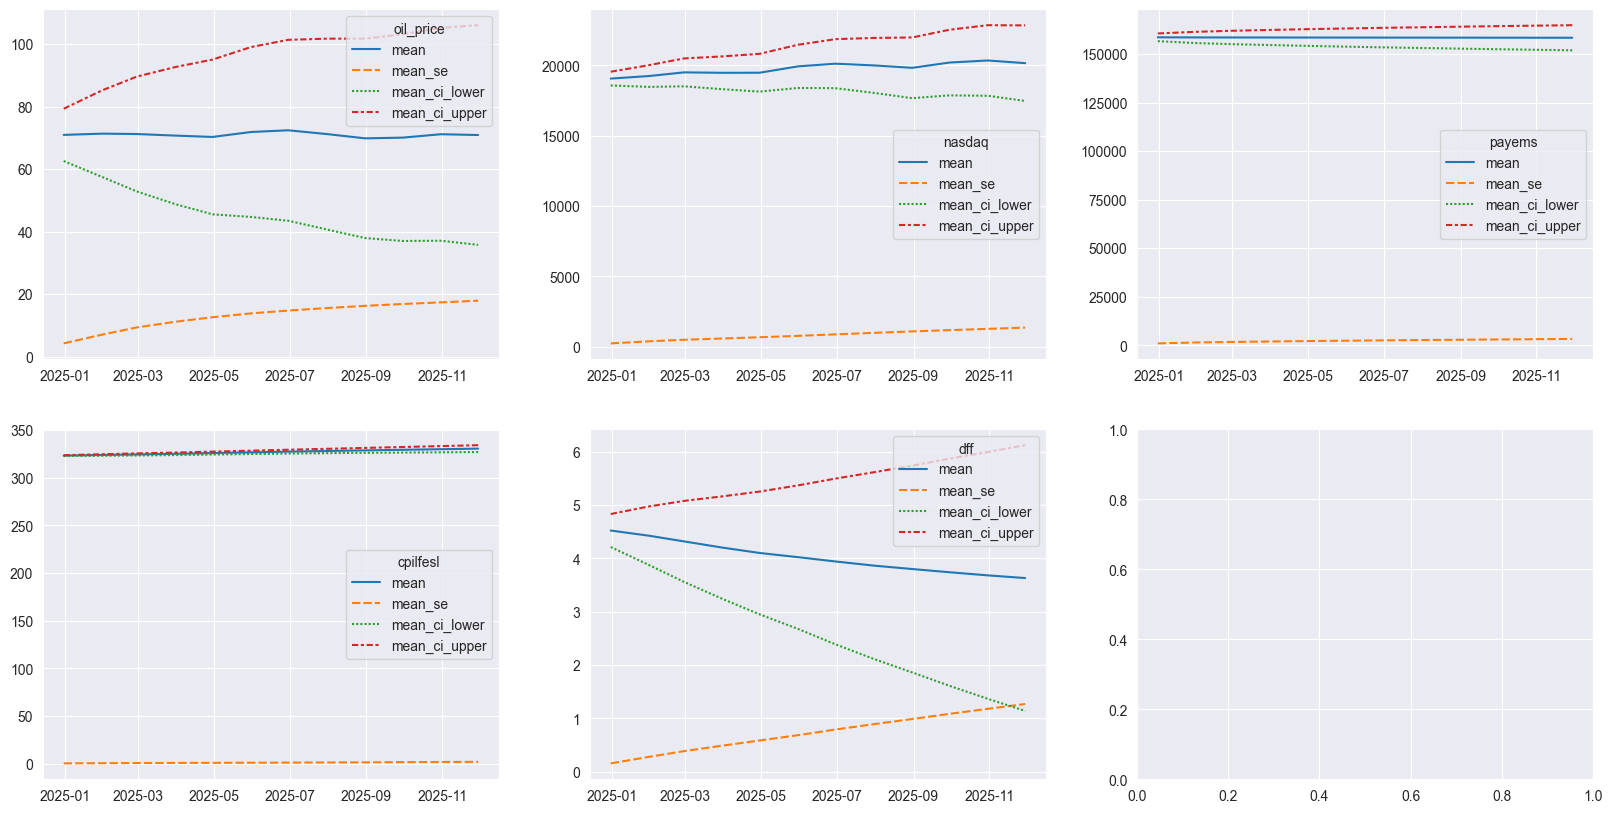

In [186]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax = ax.flatten()
arima_preds = {}
for i,c in enumerate(best_summary.keys()):
    arima_preds[f"pred_{c}"] = best_summary[c]['model'].get_forecast(steps=12).summary_frame( alpha=0.05)
    sns.lineplot(data=arima_preds[f"pred_{c}"], ax=ax[i])
plt.show()

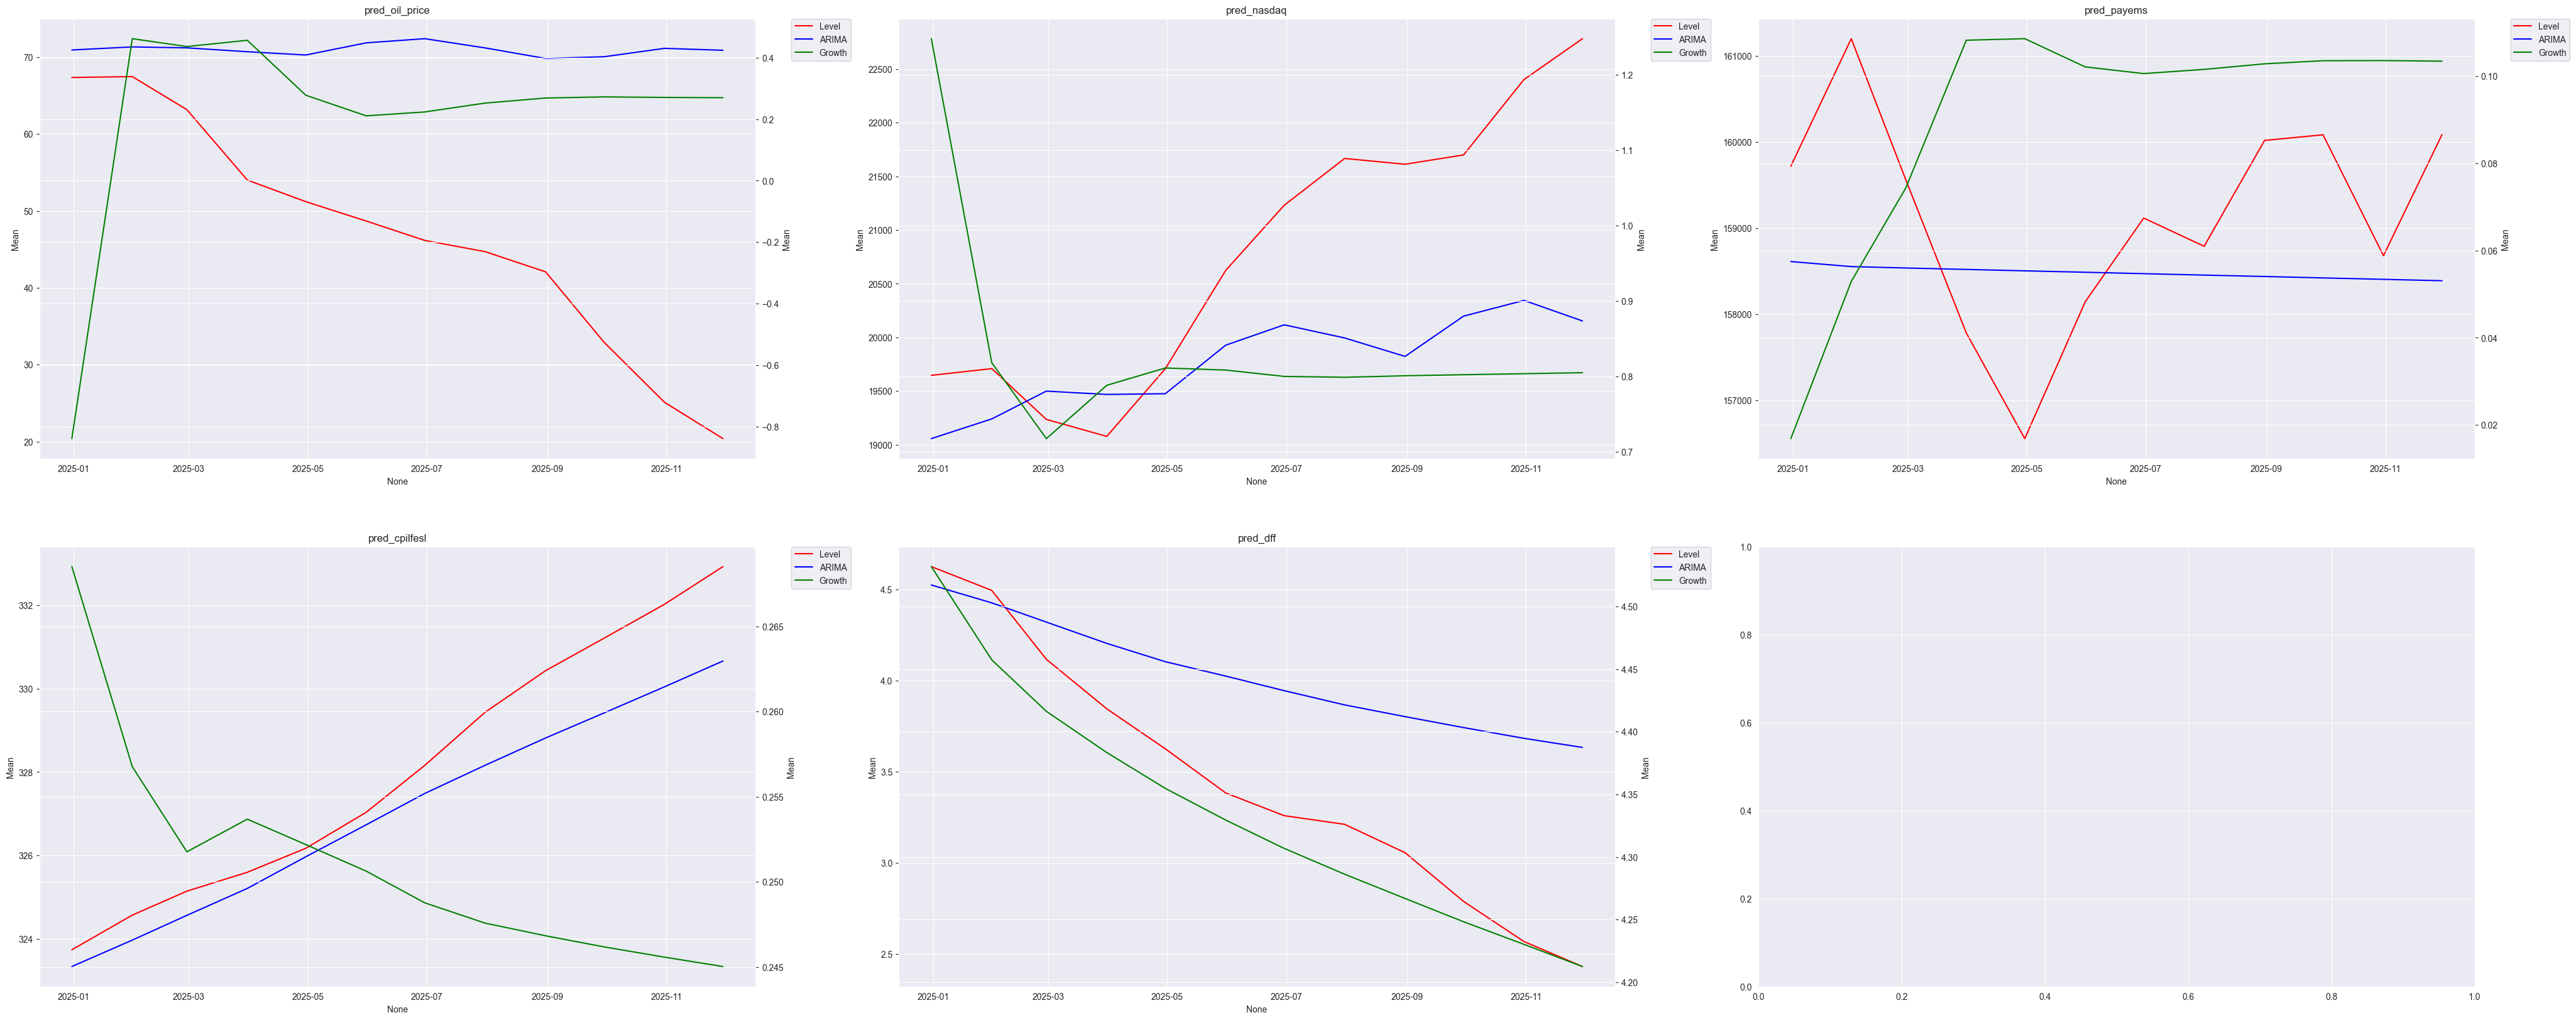

In [237]:
fig, ax = plt.subplots(2,3, figsize=(50,20))
ax = ax.flatten()
for i,k in enumerate(preds0.keys()):
    plot_data = pd.concat([preds0[k], preds1[k], arima_preds[k]['mean']], axis=1)
    plot_data.columns = ['Level', "Growth",'ARIMA']
    plot_data = pd.melt(plot_data, var_name="Dataset", value_name="Mean", ignore_index=False)
    sns.lineplot(
        data=plot_data[~plot_data.Dataset.str.contains("Growth")],
        x=plot_data[~plot_data.Dataset.str.contains("Growth")].index,
        y='Mean',
        hue="Dataset",
        ax=ax[i],
        palette = ['red','blue','green']
    )
    ax[i].set_title(k)
    ax_sec = ax[i].twinx()
    sns.lineplot(
        data=plot_data[plot_data.Dataset.str.contains("Growth")],
        x=plot_data[plot_data.Dataset.str.contains("Growth")].index,
        y='Mean',
        hue="Dataset",
        ax=ax_sec,
        palette = ['green']
    )  
    h1,l1 = ax[i].get_legend_handles_labels()
    h2,l2 = ax_sec.get_legend_handles_labels()
    ax[i].legend(h1+h2,l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax_sec.get_legend().remove()

plt.show()

We can see the ARIMA model seems to track with the level model for the cpi and dff predictors, but closer to the growth models for the others. The payems predictor is a hot mess with no obvious matching of curves besides all three being relatively flat and the mean of the level model seems to sit around the mean of the ARIMA model, but varies wildly.   

## Impluse Response

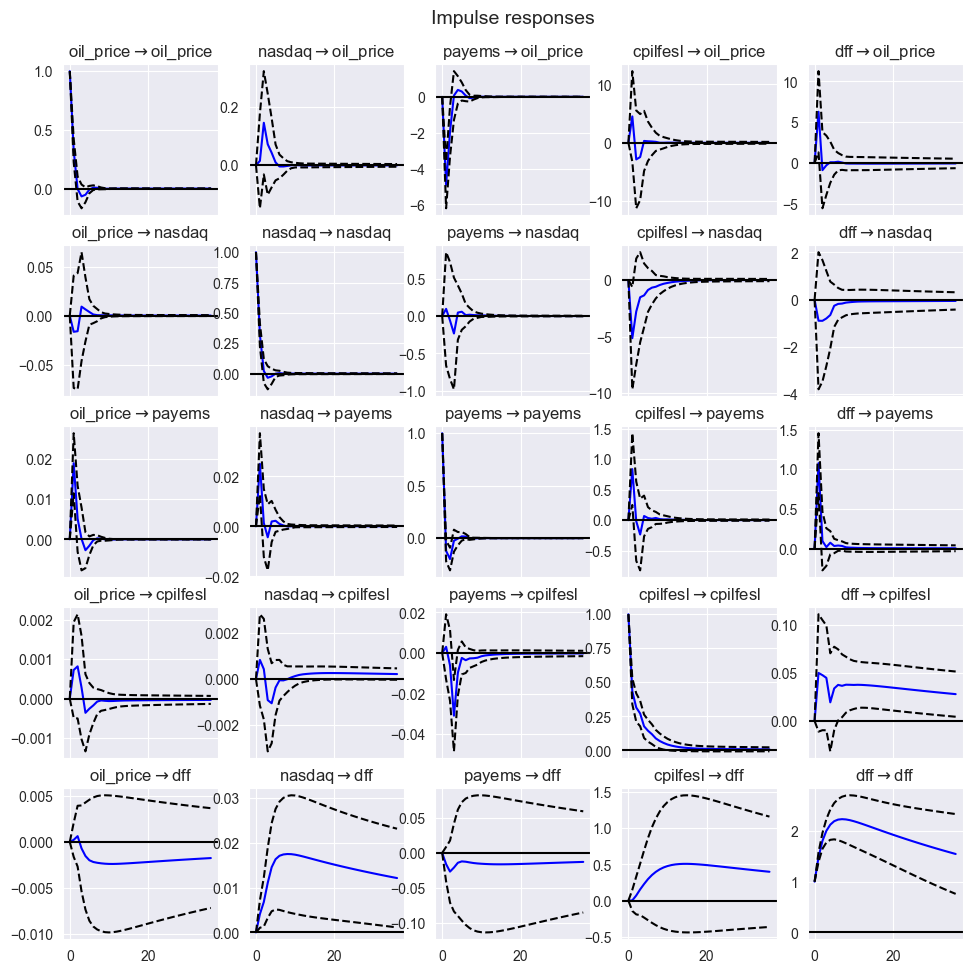

In [239]:
imp0 = model1.irf(periods=36).plot(orth=False, repl=1000)

### Describing the requested comparisons:

#### Oil -> cpi: 
We can see after the initial impulse we still have some lagging response in the signal for at least a period or two, then it sweeps negative for a couple periods, then stablizes to zero. It would appear we have some predictable response for a couple periods.
#### cpi -> dff
We can see the impact of cpi on the dff var starts off weak but generally positive for the first few periods, then increasing to a peak around 7-10 periods and slowly decaying. This predictor seems to have a strong, generally positive response for lag over 7 days.
#### dff -> payems
Dff seems to have a strong positive response at the initial impulse, but quickly drops negative for a period or two and stabilizes to zero. This relationship has a short relationship with probably just the last datapoint.
#### dff -> nasdaq
Dff initiall seems to have a generally negative relationship to nasdaq at first, but the confidence interval isn't really sure if it's positive or negative then it stabilizes to zero over time. This predictor relationship seems pretty weak and probably not of great use as our confidence intervals are both positive and negative in a significant way for the whole response. 

# Part B

## Test Errors

In [201]:
data1_g = data1.copy()
data1_g.columns = [f"{c}_g" for c in data1.columns]
errors = pd.merge(data0[data0.index > end_train], data1_g[data1_g.index > end_train].iloc[:,:-1], how='inner', left_index=True, right_index=True)
errors = pd.merge(errors, preds0, how='left', left_index=True, right_index=True)

preds1_g = preds1.copy()
preds1_g.columns = [f"{c}_g" for c in preds1.columns]
errors = pd.merge(errors, preds1_g, how='left', left_index=True, right_index=True)

arima_preds_a = pd.DataFrame({
    f"{k}_a": v['mean'].to_list() for k,v in arima_preds.items()
}, index = arima_preds['pred_oil_price'].index)
errors = pd.merge(errors, arima_preds_a, how='left', left_index=True, right_index=True)
e_cols = sorted(errors.columns)
errors = errors[e_cols]
errors['dff_g'] = errors['dff']
errors

,cpilfesl,cpilfesl_g,dff,nasdaq,nasdaq_g,oil_price,oil_price_g,payems,payems_g,pred_cpilfesl,...,pred_nasdaq,pred_nasdaq_a,pred_nasdaq_g,pred_oil_price,pred_oil_price_a,pred_oil_price_g,pred_payems,pred_payems_a,pred_payems_g,dff_g
2024-12-31,323.296,0.209625,4.475161,19734.56381,3.99663,70.118095,0.240019,158942.0,0.203426,323.737918,...,19647.106148,19058.144419,1.248193,67.353562,70.934386,-0.839422,159719.749152,158611.671763,0.016898,4.475161
2025-01-31,324.739,0.445347,4.330000,19565.04400,-0.86271,75.742500,7.715853,159067.0,0.078614,324.568374,...,19709.831232,19241.480917,0.818014,67.470255,71.331852,0.461862,161202.503927,158553.159823,0.052915,4.330000


### Best Model
It would appear the VAR growth model performed the best over all predictors considering the mean MSLE value for the predictors as seen below

VAR level mean MSLE: 0.0027510439364254358

VAR growth mean MSLE: 0.0009241796923075414

ARIMA mean MSLE: 2.454889291942768

In [240]:
col_pairs = []
for c in data0.columns:
    col_pairs.extend([
        (f'{c}_var0',f'{c}', f'pred_{c}'),
        (f'{c}_var1',f'{c}', f'pred_{c}_a'),
        (f'{c}_arima',f'{c}_g', f'pred_{c}_g')
    ]
    )

msle = {}
for cp in col_pairs:
    msle[cp[0]] = mean_squared_log_error(errors[cp[1]], errors[cp[2]]) 

var0mean_msle = sum([v for k,v in msle.items() if 'var0' in k])/3
var1mean_msle = sum([v for k,v in msle.items() if 'var1' in k])/3
arimamean_msle = sum([v for k,v in msle.items() if 'arima' in k])/3

print(f"VAR level mean MSLE: {var0mean_msle}\nVAR growth mean MSLE: {var1mean_msle}\nARIMA mean MSLE: {arimamean_msle}")

VAR level mean MSLE: 0.0027510439364254358
VAR growth mean MSLE: 0.0009241796923075414
ARIMA mean MSLE: 2.454889291942768
